In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from scipy.stats import multivariate_normal
from scipy.stats import ortho_group
from scipy import fft
import copy 

In [2]:
# utility function to generate random non singular covariance matrices with 
def generate_covariance_matrices(n_components, d):
    ans = []
    # this line imposes some structure on the covariance matrices - need to check if this is a good idea
    for i in range(n_components):
        Q = ortho_group.rvs(d)
        eps = 1e-5
        U = np.random.rand(d)*2.5 + eps
        ans.append(Q @ np.diag(U) @ Q.transpose())
    return ans

In [3]:
# gmm recovery from a synthetic gmm
# make a representative gmm
def make_gmm(n_components, n_features, random_state=0):
    gmm = GaussianMixture(n_components=n_components)
    gmm.means_ = np.random.rand(n_components, n_features) * 10
    covariance_array = generate_covariance_matrices(n_components, n_features)
    # for i in range(n_components):
    #     rand_matrix = np.random.rand(n_features, n_features)
    #     covariance_array.append(np.dot(rand_matrix, rand_matrix.T))

    gmm.covariances_ = np.array(covariance_array)

    precision_array = [np.linalg.pinv(cov) for cov in covariance_array]
    gmm.precisions_ = np.array(precision_array)
    gmm.precisions_cholesky_ = np.array([np.linalg.cholesky(prec) for prec in precision_array])
    
    gmm.weights_ = np.random.rand(n_components)
    gmm.weights_ /= np.sum(gmm.weights_)
    return gmm

In [4]:
n_components = 5
n_features = 20

oracle_gmm = make_gmm(n_components, n_features)

n_samples = 10000
X = oracle_gmm.sample(n_samples=n_samples)[0]
X_train, X_val = X[:n_samples-1500], X[n_samples-1500:]

In [5]:
# estimate the gmm
estimated_gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=10, verbose=1)
estimated_gmm.fit(X_train)

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True
Initialization 5
Initialization converged: True
Initialization 6
Initialization converged: True
Initialization 7
Initialization converged: True
Initialization 8
Initialization converged: True
Initialization 9
Initialization converged: True


GaussianMixture(n_components=5, n_init=10, verbose=1)

In [6]:
# The following code is useful for visualizing the gmm when the number of features is 2
# from matplotlib.colors import LogNorm

# # plot the estimated gmm
# x = np.linspace(-5, 15, 100)
# y = np.linspace(-5, 15, 100)
# X_grid, Y_grid = np.meshgrid(x, y)
# XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
# Z = -estimated_gmm.score_samples(XX)
# Z = Z.reshape(X_grid.shape)
# CS = plt.contour(X_grid, Y_grid, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                     levels=np.logspace(0, 3, 10))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
# plt.scatter(X_train[:, 0], X_train[:, 1], .8)

# plt.title('Negative log-likelihood predicted by a GMM')
# plt.axis('tight')
# plt.show()


In [7]:
# estimate the entropy of the gmm
def estimate_entropy_by_samples(gmm, n_samples=10000):
    X_sampled = gmm.sample(n_samples=n_samples)[0]
    log_likelihoods = gmm.score_samples(X_sampled)
    return -np.mean(log_likelihoods)

def estimate_entropy_by_data(gmm, X):
    log_likelihoods = gmm.score_samples(X)
    return -np.mean(log_likelihoods)

# estimate the entropy of the oracle gmm
oracle_entropy_sample = estimate_entropy_by_samples(oracle_gmm)
oracle_entropy_data = estimate_entropy_by_data(oracle_gmm, X)
print("oracle entropy sample: ", oracle_entropy_sample)
print("oracle entropy data: ", oracle_entropy_data)
# estimate the entropy of the estimated gmm
estimated_entropy_sample = estimate_entropy_by_samples(estimated_gmm)
estimated_entropy_data = estimate_entropy_by_data(estimated_gmm, X_train)
print("estimated entropy sample: ", estimated_entropy_sample)
print("estimated entropy data: ", estimated_entropy_data)

oracle entropy sample:  29.518218825215655
oracle entropy data:  29.619114501224807
estimated entropy sample:  29.274477897393034
estimated entropy data:  29.218631585359123


In [8]:
estimated_entropy = estimated_entropy_data

anomalous_data_length = [pow(2, i) for i in range(1, 11)]
confidence = 0.9
K = 1000

def get_epsilon_for_confidence(confidence, test_gmm, estimated_entropy, X_val):
    epsilon_m = []
    for m in anomalous_data_length:
        # using bootstrap method to calculate epsilon with 90% confidence interval for each m
        vals = []
        for _ in range(K):
            # use X_val and bootstrap m samples from it
            sample_set = resample(X_val, n_samples=m)
            # calculate the entropy of the sample set
            sample_entropy = estimate_entropy_by_data(test_gmm, sample_set)
            vals.append(abs(sample_entropy - estimated_entropy))
        vals.sort()
        # print(vals)
        epsilon_m.append(vals[int(K * confidence)])
    return epsilon_m

epsilon_m = get_epsilon_for_confidence(confidence, estimated_gmm, estimated_entropy, X_val)
print(epsilon_m)

[5.924348827942854, 4.846526595719229, 4.367053223677235, 3.9627171728562693, 3.5455780372689496, 3.3778948386928427, 3.169825413609903, 3.1145590982460156, 3.0156874048984257, 2.974364011290067]


type-1 error for m=2: 3.3 %
type-1 error for m=4: 1.2 %
type-1 error for m=8: 0.8 %
type-1 error for m=16: 0.0 %
type-1 error for m=32: 0.0 %
type-1 error for m=64: 0.0 %
type-1 error for m=128: 0.0 %
type-1 error for m=256: 0.0 %
type-1 error for m=512: 0.0 %
type-1 error for m=1024: 0.0 %


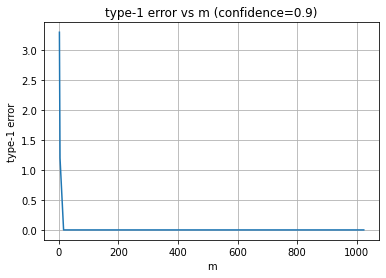

In [9]:
# type-1 error calculation
# error_wrt_m = []
# for m in anomalous_data_length:
#     errors = 0
#     for _ in range(K):
#         sample_set = oracle_gmm.sample(n_samples=m)[0]
#         sample_entropy = estimate_entropy_by_data(estimated_gmm, sample_set)
#         if abs(sample_entropy - estimated_entropy) > epsilon_m[int(np.log2(m))-1]:
#             errors += 1
#     print(f"type-1 error for m={m}: {errors*100/K} %")
#     error_wrt_m.append(errors*100/K)

# plt.figure()
# plt.plot(anomalous_data_length, error_wrt_m)
# plt.grid()
# plt.xlabel("m")
# plt.ylabel("type-1 error")
# plt.title("type-1 error vs m")
# plt.show()

error_wrt_m = []
for m in anomalous_data_length:
    errors = 0
    for _ in range(K):
        sample_set = oracle_gmm.sample(n_samples=m)[0]
        sample_entropy = estimate_entropy_by_data(estimated_gmm, sample_set)
        if abs(sample_entropy - estimated_entropy) > epsilon_m[int(np.log2(m))-1]:
            errors += 1
    print(f"type-1 error for m={m}: {errors*100/K} %")
    error_wrt_m.append(errors*100/K)

plt.figure()
plt.plot(anomalous_data_length, error_wrt_m)
plt.grid()
plt.xlabel("m")
plt.ylabel("type-1 error")
plt.title(f"type-1 error vs m (confidence={confidence})")
plt.show()

In [10]:
# building an anomalous data set to test the type-2 error
def get_random_unit_vector(n):
    v = np.random.normal(size=n)
    return v/np.linalg.norm(v)

# utility function to shift gmm
def shift_gmm(original_gmm, fc):
    # shift means randomly by fc% of its norm and copy everything else as is
    for i in range(n_components):
        original_gmm.means_[i] = original_gmm.means_[i] + (fc * np.linalg.norm(original_gmm.means_[i]) * get_random_unit_vector(n_features))
        original_gmm.covariances_[i] = original_gmm.covariances_[i]
        original_gmm.precisions_[i] = original_gmm.precisions_[i]
        original_gmm.precisions_cholesky_[i] = original_gmm.precisions_cholesky_[i]
        original_gmm.weights_ = original_gmm.weights_

    return original_gmm

identity_matrix = np.eye(n_features)
def mean_type_2_error(oracle_gmm, estimated_gmm, epsilon_m, K, deviation_factor, estimated_entropy, measurement_matrix = identity_matrix):
    # type-2 error calculation
    error_wrt_m_mean = np.zeros(len(anomalous_data_length))

    for shf_cnt in range(5):
        print(f"-------------- shift count: {shf_cnt+1} --------------")
        error_wrt_m = np.zeros(len(anomalous_data_length))
        shifted_gmm = copy.deepcopy(oracle_gmm)
        shifted_gmm = shift_gmm(shifted_gmm, deviation_factor)

        # shifted_samples = shifted_gmm.sample(n_samples=5000)[0]
        # plot the shifted gmm -> in case the number of features is 2
        # if(shf_cnt < 10):
        #     plt.figure(shf_cnt+1)
        #     x = np.linspace(-5, 15, 100)
        #     y = np.linspace(-5, 15, 100)
        #     X_grid, Y_grid = np.meshgrid(x, y)
        #     XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
        #     Z = -shifted_gmm.score_samples(XX)
        #     Z = Z.reshape(X_grid.shape)
        #     CS = plt.contour(X_grid, Y_grid, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
        #                         levels=np.logspace(0, 3, 10))
        #     CB = plt.colorbar(CS, shrink=0.8, extend='both')
        #     plt.scatter(shifted_samples[:, 0], shifted_samples[:, 1], .8)
        #     plt.title('Negative log-likelihood predicted by a shifted GMM')
        #     plt.axis('tight')
        #     plt.show()

        for m in anomalous_data_length:
            # type-2 error calculation
            errors = 0
            for _ in range(K):
                sample_set = shifted_gmm.sample(n_samples=m)[0] @ measurement_matrix.T
                sample_entropy = estimate_entropy_by_data(estimated_gmm, sample_set)
                if abs(sample_entropy - estimated_entropy) <= epsilon_m[int(np.log2(m))-1]:
                    errors += 1
            error_wrt_m[int(np.log2(m))-1] = errors*100/K
            print(f"type-2 error for m={m}: {errors*100/K} %")
        error_wrt_m_mean += error_wrt_m

    error_wrt_m_mean = error_wrt_m_mean/5
    return error_wrt_m_mean

# shift of the gmm components is 5% of the norm of the mean
avg_error_wrt_m = mean_type_2_error(oracle_gmm, estimated_gmm, epsilon_m, K, 0.1, estimated_entropy)


-------------- shift count: 1 --------------
type-2 error for m=2: 39.1 %
type-2 error for m=4: 20.4 %
type-2 error for m=8: 5.0 %
type-2 error for m=16: 0.2 %
type-2 error for m=32: 0.0 %
type-2 error for m=64: 0.0 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 2 --------------
type-2 error for m=2: 42.4 %
type-2 error for m=4: 23.0 %
type-2 error for m=8: 10.4 %
type-2 error for m=16: 1.2 %
type-2 error for m=32: 0.0 %
type-2 error for m=64: 0.0 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 3 --------------
type-2 error for m=2: 45.4 %
type-2 error for m=4: 21.8 %
type-2 error for m=8: 6.5 %
type-2 error for m=16: 1.3 %
type-2 error for m=32: 0.0 %
type-2 error for m=64: 0.0 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error 

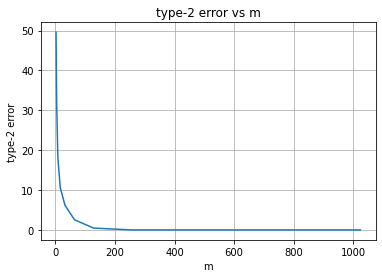

,m,type-1 error,type-2 error
0,2,3.3,49.58
1,4,1.2,31.90
2,8,0.8,18.22
3,16,0.0,10.64
4,32,0.0,6.18
5,64,0.0,2.54
6,128,0.0,0.46
7,256,0.0,0.00
8,512,0.0,0.00
9,1024,0.0,0.00


In [11]:
import pandas as pd
plt.plot(anomalous_data_length, avg_error_wrt_m)
plt.grid()
plt.xlabel("m")
plt.ylabel("type-2 error")
plt.title("type-2 error vs m")
plt.show()
df = pd.DataFrame({'m': anomalous_data_length, 'type-1 error': error_wrt_m, 'type-2 error': avg_error_wrt_m})
df

Now let us do type-1 and type-2 error calculation for the typicality test in the compressed domain. We use a random binomial sensing matrix [entries = (+1,-1)] to compress the data and perform the tests with different values of the compression ratio to see the effect of compression on the type-1 and type-2 error rates.

In [12]:
measurement_matrices = []
for i in range(10):
    n_measurements = ((i+1)*n_features)//10
    # measurement_matrices.append(np.random.randn(n_measurements, n_features))
    measurement_matrices.append(np.random.binomial(1, 0.5, size=(n_measurements, n_features))*2 - 1)

noise_std_dev = 0.0005

def form_y_gmms(x_gmm, measurement_matrices):
    gmm_list = []
    
    for i in range(len(measurement_matrices)):
        n_measurements = measurement_matrices[i].shape[0]
        noise_covariance_matrix = np.eye(n_measurements) * (noise_std_dev * noise_std_dev)
        noise_inverse = np.linalg.inv(noise_covariance_matrix)

        gmm_sample = GaussianMixture(n_components=n_components, random_state=0)
        gmm_sample.means_ = x_gmm.means_ @ measurement_matrices[i].T
        covariance_array = []

        for j in range(n_components):
            # C_ij = np.linalg.pinv(measurement_matrices[i].T @ noise_inverse @ measurement_matrices[i] + x_gmm.precisions_[j])
            # temp_matrix = noise_inverse @ measurement_matrices[i] @ C_ij @ measurement_matrices[i].T @ noise_inverse
            # covariance_array.append(np.linalg.pinv(noise_inverse - temp_matrix))
            covariance_array.append(noise_covariance_matrix  + measurement_matrices[i] @ x_gmm.covariances_[j] @ measurement_matrices[i].T)

        gmm_sample.covariances_ = np.array(covariance_array)
        gmm_sample.weights_ = x_gmm.weights_

        precision_array = [np.linalg.pinv(covariance_array[i]) for i in range(n_components)]
        gmm_sample.precisions_ = np.array(precision_array)
        gmm_sample.precisions_cholesky_ = np.array([np.linalg.cholesky(precision_array[i]) for i in range(n_components)])
        
        gmm_list.append(gmm_sample)
    return gmm_list

y_gmms = form_y_gmms(estimated_gmm, measurement_matrices)

num-measurements: 2 / 20
estimated entropy for compressed gmm: 6.6371916175526255
num-measurements: 4 / 20
estimated entropy for compressed gmm: 13.031447979835413
num-measurements: 6 / 20
estimated entropy for compressed gmm: 18.963729104096746
num-measurements: 8 / 20
estimated entropy for compressed gmm: 24.631105063668166
num-measurements: 10 / 20
estimated entropy for compressed gmm: 30.226898778539756
num-measurements: 12 / 20
estimated entropy for compressed gmm: 34.81219219734601
num-measurements: 14 / 20
estimated entropy for compressed gmm: 39.43436954692348
num-measurements: 16 / 20
estimated entropy for compressed gmm: 43.65825829726228
num-measurements: 18 / 20
estimated entropy for compressed gmm: 48.65312340520218
num-measurements: 20 / 20
estimated entropy for compressed gmm: 50.34700493370388


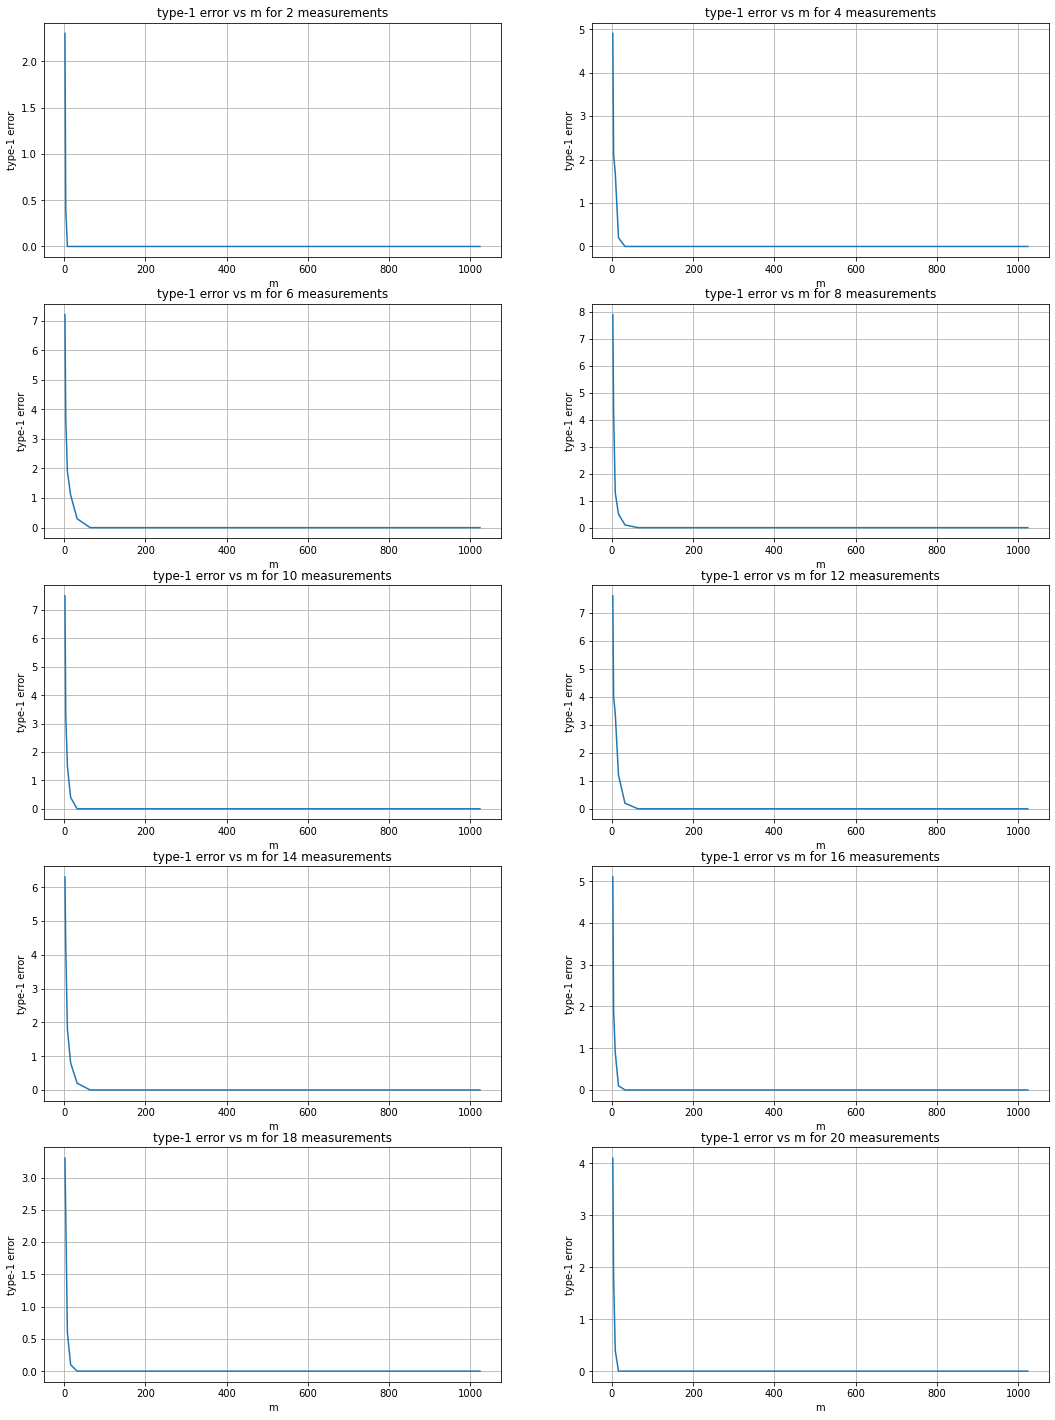

In [13]:
# type-1 error calculation

fig, ax = plt.subplots(5, 2, figsize = (18, 25))
for i,measurement_matrix in enumerate(measurement_matrices):
    error_wrt_m = []
    n_measurements = measurement_matrix.shape[0]
    print(f"num-measurements: {n_measurements} / 20")
    estimated_entropy_m = estimate_entropy_by_data(y_gmms[i], X_train @ measurement_matrix.T)
    # estimated_entropy_m_by_gmm = estimate_entropy_by_samples(y_gmms[i])
    print(f"estimated entropy for compressed gmm: {estimated_entropy_m}")
    # print(f"estimated entropy for compressed gmm by samples: {estimated_entropy_m_by_gmm}")
    
    epsilon_m = get_epsilon_for_confidence(confidence, y_gmms[i], estimated_entropy_m, X_val @ measurement_matrix.T)
    # print(f"epsilon_m: {epsilon_m}")
    
    for m in anomalous_data_length:
        errors = 0
        for _ in range(K):
            sample_set = oracle_gmm.sample(n_samples=m)[0]
            sample_set = sample_set @ measurement_matrix.T
            sample_entropy = estimate_entropy_by_data(y_gmms[i], sample_set)
            if abs(sample_entropy - estimated_entropy_m) > epsilon_m[int(np.log2(m))-1]:
                errors += 1
        # print(f"type-1 error for m={m}: {errors*100/K} %")
        error_wrt_m.append(errors*100/K)

    
    ax[i//2][i%2].plot(anomalous_data_length, error_wrt_m)
    ax[i//2][i%2].grid()
    ax[i//2][i%2].set_xlabel("m")
    ax[i//2][i%2].set_ylabel("type-1 error")
    ax[i//2][i%2].set_title(f"type-1 error vs m for {n_measurements} measurements")

plt.show()

num-measurements: 2 / 20
estimated entropy for compressed gmm: 6.6371916175526255
-------------- shift count: 1 --------------
type-2 error for m=2: 94.9 %
type-2 error for m=4: 97.7 %
type-2 error for m=8: 98.4 %
type-2 error for m=16: 99.9 %
type-2 error for m=32: 100.0 %
type-2 error for m=64: 100.0 %
type-2 error for m=128: 100.0 %
type-2 error for m=256: 100.0 %
type-2 error for m=512: 100.0 %
type-2 error for m=1024: 100.0 %
-------------- shift count: 2 --------------
type-2 error for m=2: 97.3 %
type-2 error for m=4: 98.7 %
type-2 error for m=8: 99.9 %
type-2 error for m=16: 100.0 %
type-2 error for m=32: 100.0 %
type-2 error for m=64: 100.0 %
type-2 error for m=128: 100.0 %
type-2 error for m=256: 100.0 %
type-2 error for m=512: 100.0 %
type-2 error for m=1024: 100.0 %
-------------- shift count: 3 --------------
type-2 error for m=2: 97.8 %
type-2 error for m=4: 99.1 %
type-2 error for m=8: 99.9 %
type-2 error for m=16: 100.0 %
type-2 error for m=32: 100.0 %
type-2 error for 

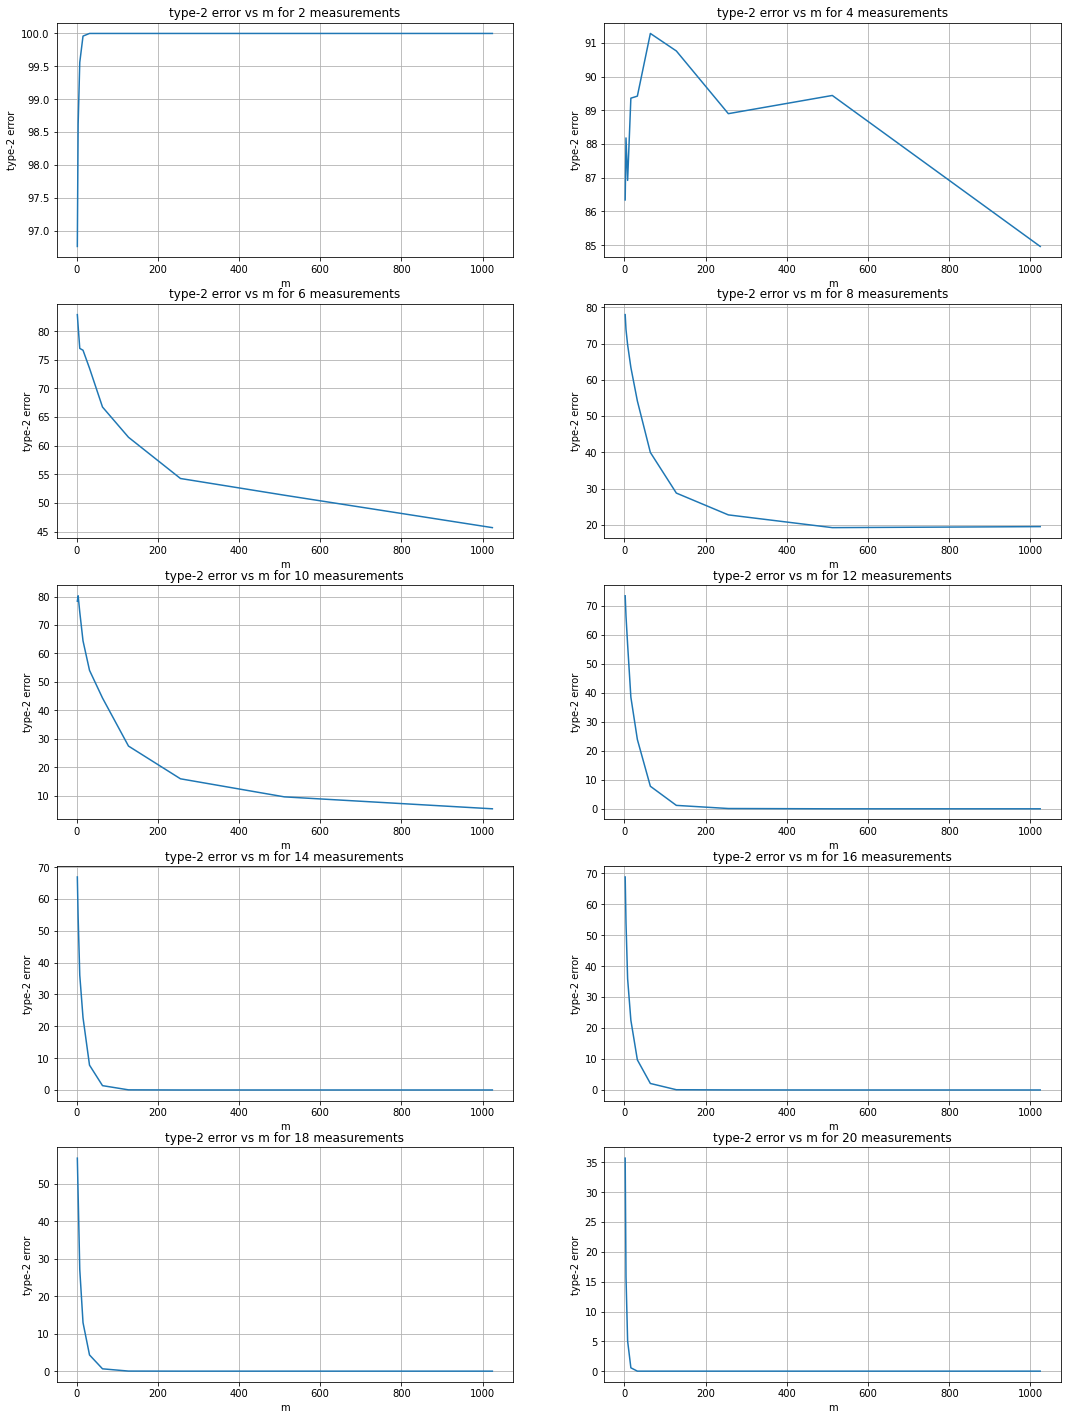

In [14]:
deviation_factor = 0.1
fig, ax = plt.subplots(5, 2, figsize = (18, 25))
for i, measurement_matrix in enumerate(measurement_matrices):
    n_measurements = measurement_matrix.shape[0]
    print(f"num-measurements: {n_measurements} / 20")
    estimated_entropy_m = estimate_entropy_by_data(y_gmms[i], X_train @ measurement_matrix.T)
    # estimated_entropy_m_by_gmm = estimate_entropy_by_samples(y_gmms[i])
    print(f"estimated entropy for compressed gmm: {estimated_entropy_m}")
    # print(f"estimated entropy for compressed gmm by samples: {estimated_entropy_m_by_gmm}")
    
    epsilon_m = get_epsilon_for_confidence(confidence, y_gmms[i], estimated_entropy_m, X_val @ measurement_matrix.T)

    avg_error_wrt_m = mean_type_2_error(oracle_gmm, y_gmms[i], epsilon_m, K, deviation_factor, estimated_entropy_m, measurement_matrix)
    print(f"avg type-2 error for {n_measurements} measurements: {avg_error_wrt_m}")
    ax[i//2][i%2].plot(anomalous_data_length, avg_error_wrt_m)
    ax[i//2][i%2].grid()
    ax[i//2][i%2].set_xlabel("m")
    ax[i//2][i%2].set_ylabel("type-2 error")
    ax[i//2][i%2].set_title(f"type-2 error vs m for {n_measurements} measurements")

plt.show()
